**Key Questions to Address:**
1. What is **FBProphet** Model?
2. How is it utilized for Forecasting a Time Series?
3. Why is it significant?
4. What is the corresponding mathematical formula?
5. How can it be implemented in Python and Machine Learning?

### 1. **What is the FBProphet Model?**
- FBProphet is an open-source forecasting tool developed by Facebook, designed for forecasting time series data exhibiting daily, weekly, and yearly seasonality.
- It handles events like holidays and special events, making it practical for real-world business applications.
- The model is robust to missing data and outliers and automatically detects and adjusts for trend changes.

### 2. **How is it Utilized for Forecasting a Time Series?**
FBProphet is designed to be user-friendly and suitable for non-experts. It decomposes a time series into three components:
   - **Trend**: Captures the long-term increase or decrease in the data.
   - **Seasonality**: Models recurring cycles within the data, such as daily, weekly, and yearly patterns.
   - **Holidays**: Accounts for the effects of holidays or special events.

The model fits historical data and generates future forecasts by analyzing these components using an additive approach to time series forecasting, making it interpretable and flexible.

### 3. **Why is it Significant?**
FBProphet stands out for several reasons:
   - **Scalability**: It handles large datasets, making it suitable for applications like sales forecasting or website traffic analysis.
   - **Flexibility**: It supports custom seasonalities and holidays and can deal with missing or irregular data.
   - **Ease of Use**: Users can obtain accurate forecasts with minimal model tuning, even without deep statistical expertise.
   - **Automatic Trend Changes**: It detects and adapts to changes in the trend, which is crucial for dynamic environments.

### 4. **Mathematical Formula**
FBProphet uses an **additive model**, mathematically expressed as:

$$
y(t) = g(t) + s(t) + h(t) + \epsilon_t
$$

Where:
   - $y(t)$: The time series value at time $t$.
   - $g(t)$: The trend function representing non-periodic changes.
   - $s(t)$: The seasonal component modeling recurring patterns.
   - $h(t)$: The effect of holidays or special events.
   - $\epsilon_t$: The error term accounting for unmodeled changes.

The trend $g(t)$ can be either linear or piecewise linear, with automatic detection of changepoints.
The seasonality $s(t)$ is modeled using Fourier series.

---

### Data
- The data we will be using is hourly power consumption data from PJM.
- Energy consumption has some unique characteristics. It will be interesting to see how prophet picks them up.

**Pulling the PJM East which has data from 2002-2018 for the entire east region**.

---

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error
color_pal = sns.color_palette()
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [15]:
# Upload the dataset
pjme = pd.read_csv('PJME_hourly.csv',
                 index_col=[0],
                 parse_dates=[0])
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


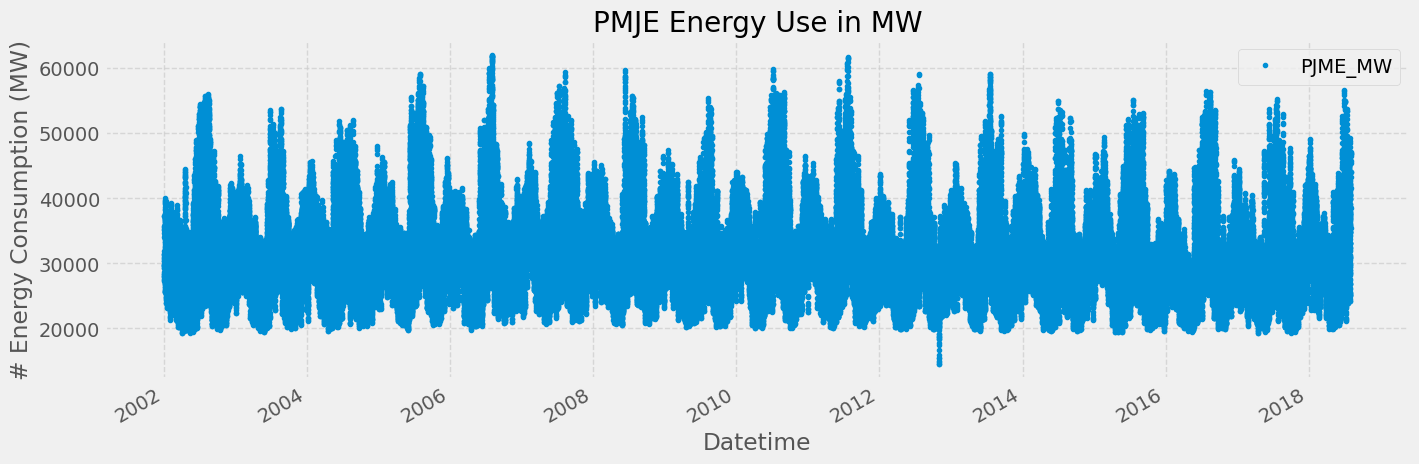

In [16]:
# Visualize the Time Series
pjme.plot(
    style='.',                       # Use dots to represent data points in the plot
    figsize=(15, 5),                 # Set the size of the plot (width=15, height=5)
    color=color_pal[0],              # Choose a color for the plot (can be modified as needed)
    title='PMJE Energy Use in MW',   # Title of the plot
    xlabel='Datetime',                   # Label for the x-axis
    ylabel='# Energy Consumption (MW)' # Label for the y-axis
)
plt.grid(visible=True, linestyle='--', alpha=0.7) # Deactivate the grid use 'False
plt.show()

### Time Series Features:
- We do not need them for Ptophet model, we just use them to see how the data looks like

In [21]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week #df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300 # This formula transforms the date into a number (likely a day of the year) that "wraps around" after a certain point, creating a pseudo-day-of-year value. 

    df['season'] = pd.cut(df['date_offset'], 
                          [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    """
    [0, 300, 602, 900, 1300] (Bins): These numbers represent the edges of the bins or intervals for dividing date_offset into seasons.
    Each bin defines a range, and the values in df['date_offset'] will fall into one of these ranges:

            0 to 300 -> Spring
            301 to 602 -> Summer
            603 to 900 -> Fall
            901 to 1300 -> Winter
    """
    X = df[['hour','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear','weekday','season']]
    if label:
        y = df[label]
        return X, y
    return X
X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

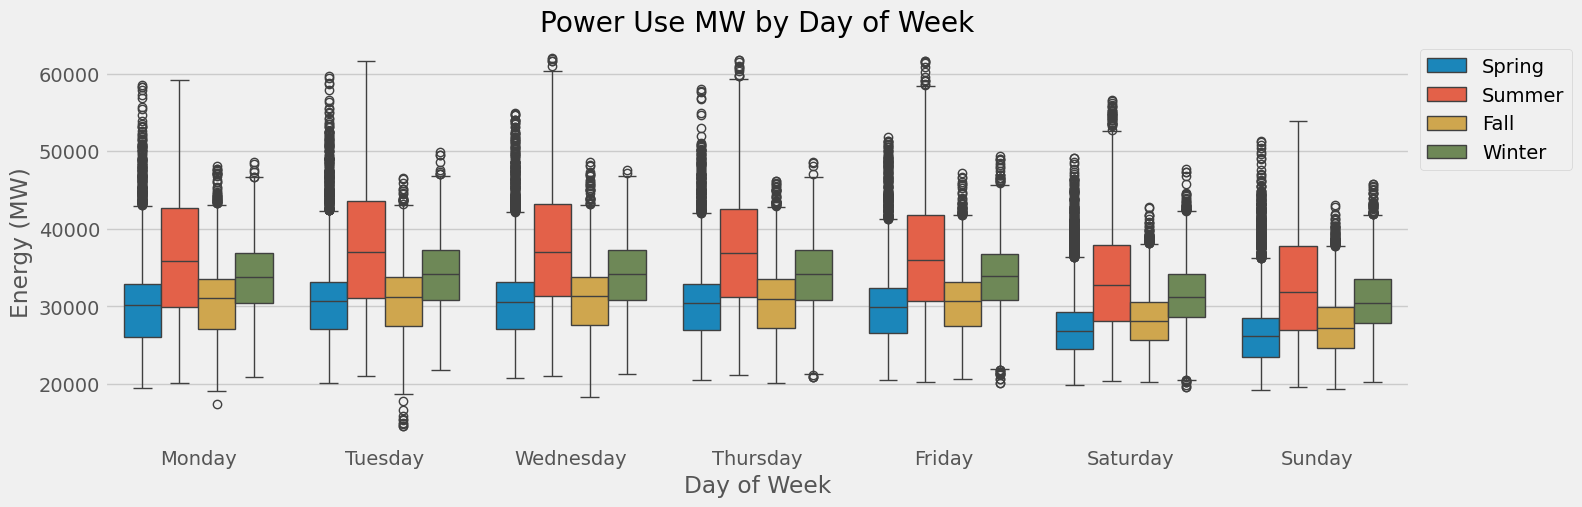

In [26]:
# Plot them
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

### Train / Test Split

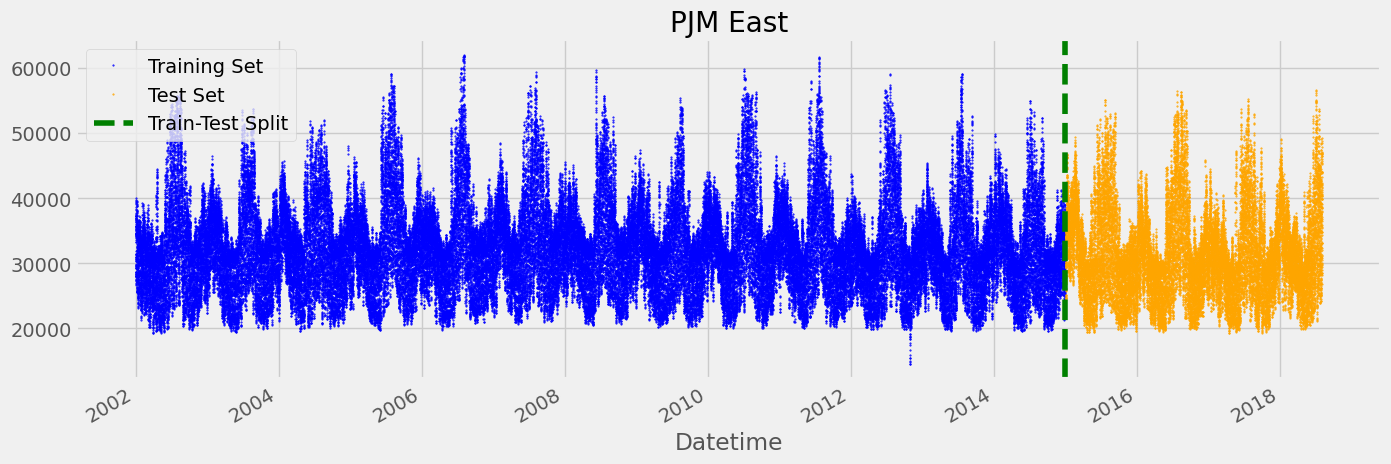

In [33]:
# Split the dataset into "training set" and "test set"
split_date = '1-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

# Plot train and test so you can see where we have split
ax = pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}).plot(figsize=(15, 5), 
                                                                 title='PJM East', 
                                                                 style='.', 
                                                                 ms=1, 
                                                                 color='blue', 
                                                                 label='TRAINING SET')

pjme_test.rename(columns={'PJME_MW': 'TEST SET'}).plot(ax=ax, 
                                                       style='.', 
                                                       ms=1, 
                                                       color='orange', 
                                                       label='TEST SET')

plt.axvline('01-01-2015', color='green', linestyle='--', label='Train-Test Split')

plt.legend(['Training Set','Test Set', 'Train-Test Split'])
plt.show()


### Simple Prophet Model
- `Prophet model expects the dataset to be named a specific way`.
- We will rename our dataframe columns before feeding it into the model.

    - Datetime column named: `ds`
    - target : `y`

In [39]:
# Format data for prophet model using ds and y
# training set
pjme_train_prophet = pjme_train.reset_index().rename(columns={'Datetime':'ds',
                                                              'PJME_MW':'y'})

# test set
pjme_test_prophet = pjme_test.reset_index().rename(columns={'Datetime':'ds',
                                                              'PJME_MW':'y'})

In [38]:
# Train the model in 'training set'
import time
# Start time
start_time = time.time()

# Define the model
model = Prophet()
model.fit(pjme_train_prophet)

# End time and print the elapsed time
end_time = time.time()
print(f"Model training took {end_time - start_time:.2f} seconds")

12:41:15 - cmdstanpy - INFO - Chain [1] start processing
12:43:12 - cmdstanpy - INFO - Chain [1] done processing


Model training took 137.52 seconds


In [40]:
# Make prediction:
pjme_test_fcst = model.predict(pjme_test_prophet)

In [43]:
# 'yhat' is the predicted data
pjme_test_fcst.head(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31214.420813,23620.245508,32983.321428,31214.420813,31214.420813,-2835.417939,-2835.417939,-2835.417939,-4430.360197,...,1281.390107,1281.390107,1281.390107,313.552151,313.552151,313.552151,0.0,0.0,0.0,28379.002874
1,2015-01-01 02:00:00,31214.383693,22843.430178,31829.427600,31214.383693,31214.383693,-4339.789544,-4339.789544,-4339.789544,-5927.274407,...,1272.632061,1272.632061,1272.632061,314.852802,314.852802,314.852802,0.0,0.0,0.0,26874.594149
2,2015-01-01 03:00:00,31214.346573,21213.094092,30372.002511,31214.346573,31214.346573,-5211.485567,-5211.485567,-5211.485567,-6790.348748,...,1262.668237,1262.668237,1262.668237,316.194944,316.194944,316.194944,0.0,0.0,0.0,26002.861007


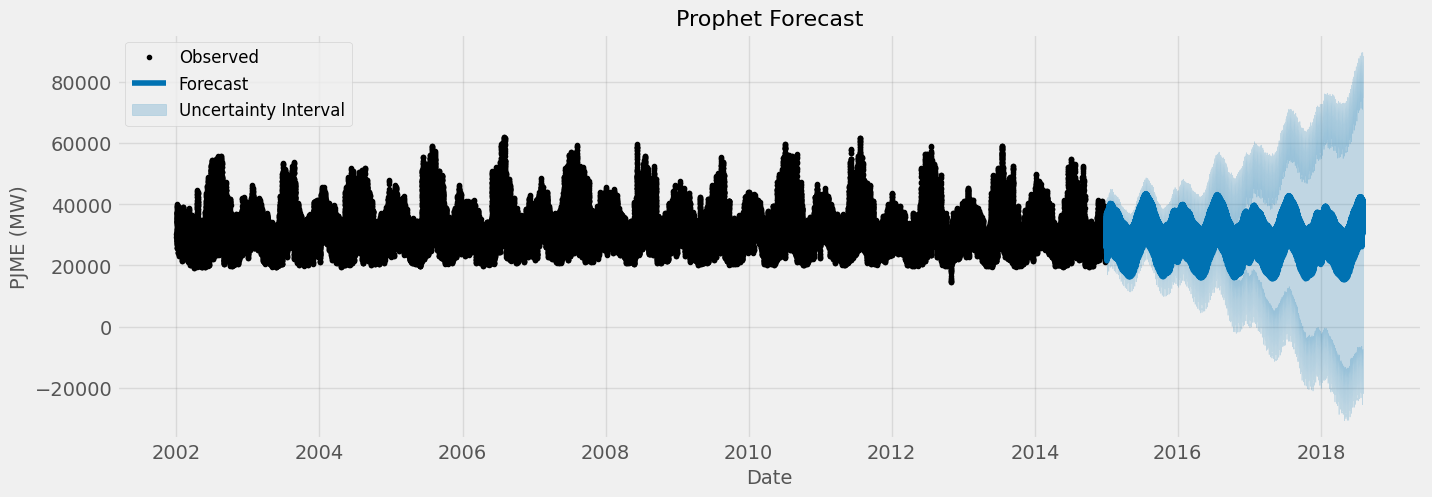

In [45]:
# Visualize the Forecast
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the forecast with the model
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('PJME (MW)', fontsize=14)

# Add a legend to the plot
ax.legend(['Observed', 'Forecast', 'Uncertainty Interval'], fontsize=12)

# Show the plot
plt.show()


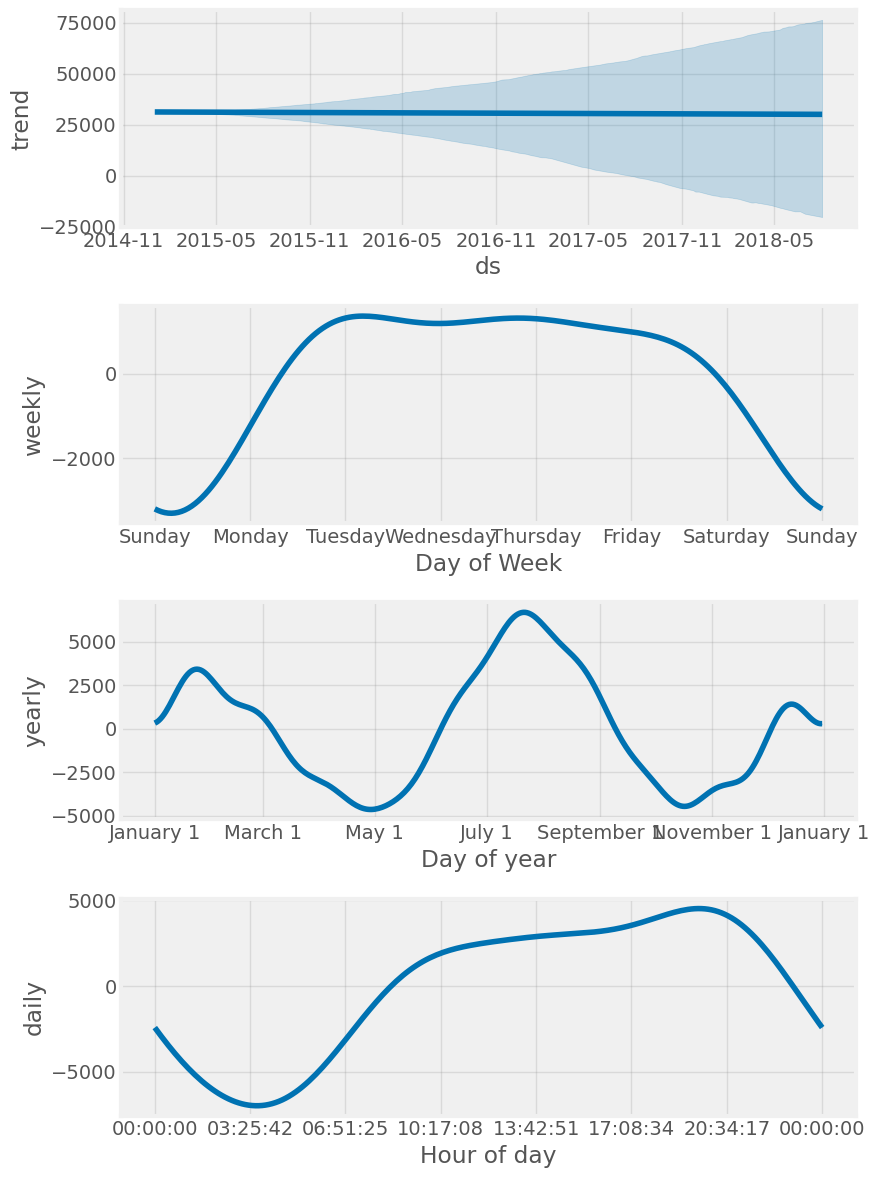

In [48]:
# Visualize the components
fig = model.plot_components(pjme_test_fcst)
plt.show()

### Compare Forecast to Actuals

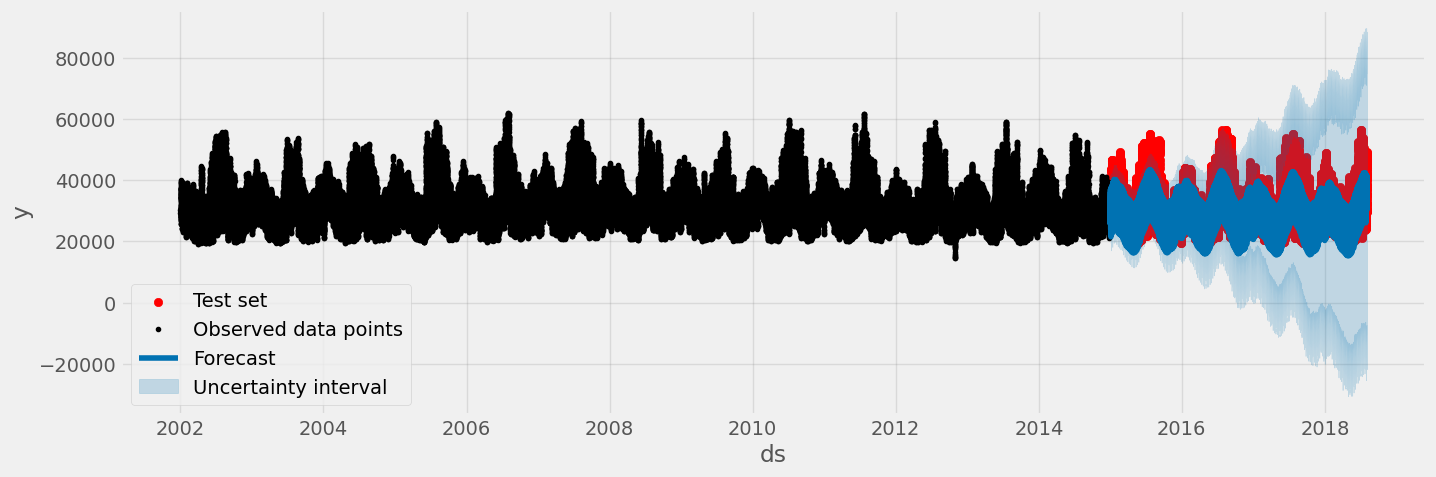

In [55]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r', label='Test set')
fig = model.plot(pjme_test_fcst, ax=ax)
plt.legend()
plt.show()

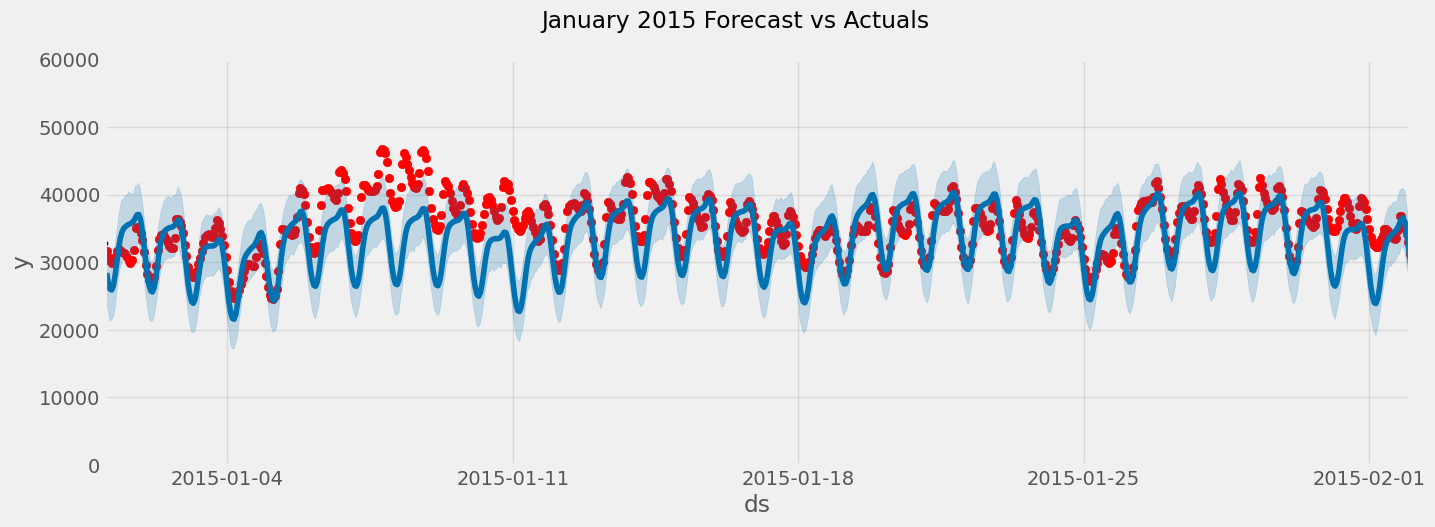

In [60]:
# Forecasting for a specific date
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, 
           pjme_test['PJME_MW'], 
           color='r')

fig = model.plot(pjme_test_fcst, 
                 ax=ax)
ax.set_xbound(lower=pd.to_datetime('2015-01-01'), 
              upper=pd.to_datetime('2015-02-02'))
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

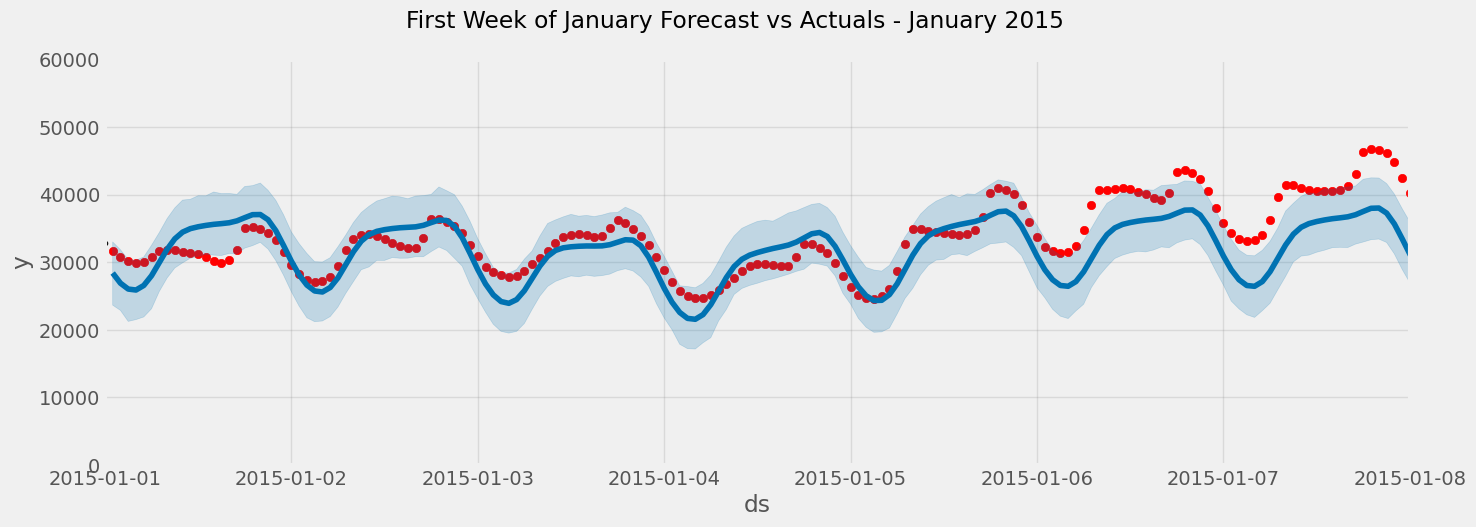

In [67]:
# First Week of January Forecast vs Actuals

fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, 
           pjme_test['PJME_MW'], 
           color='r')

fig = model.plot(pjme_test_fcst, 
                 ax=ax)
ax.set_xbound(lower=pd.to_datetime('2015-01-01'), 
              upper=pd.to_datetime('2015-01-08'))
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals - January 2015')

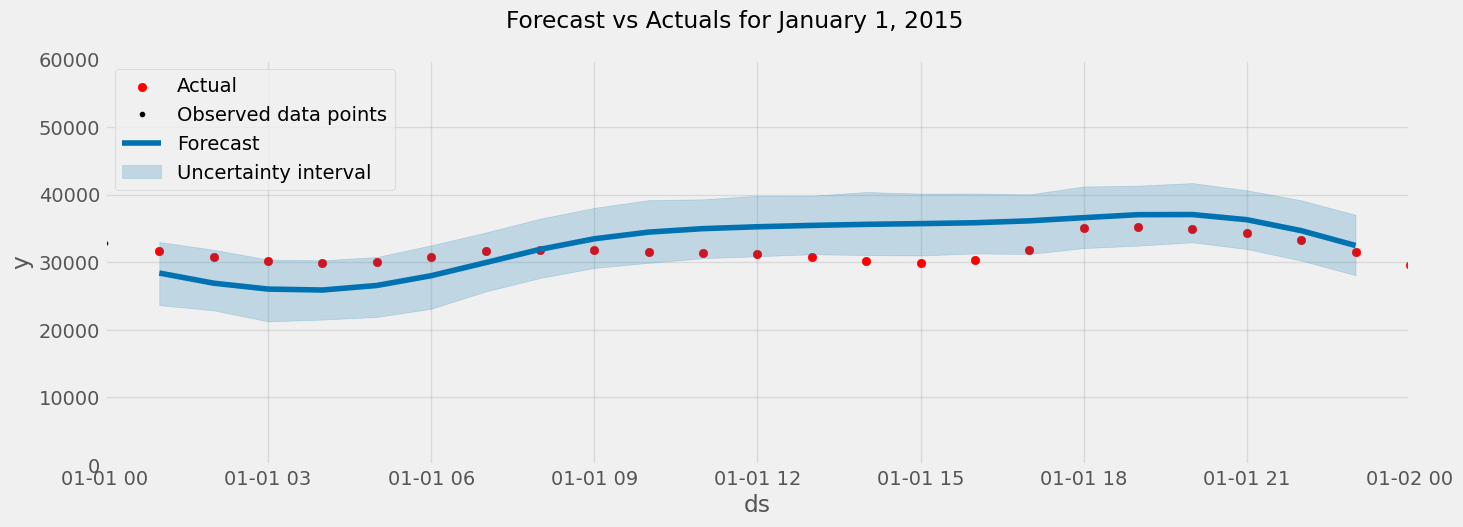

In [68]:
# One day forecast
import pandas as pd
import matplotlib.pyplot as plt

# Assuming pjme_test is your actual data DataFrame and pjme_test_fcst is your forecast DataFrame

# Filter forecast data for January 1, 2015
pjme_test_fcst_filtered = pjme_test_fcst[
    (pjme_test_fcst['ds'] >= '2015-01-01 00:00:00') & 
    (pjme_test_fcst['ds'] <= '2015-01-01 23:58:00')
]

# First Day of January Forecast vs Actuals
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the actual data
ax.scatter(pjme_test.index, 
           pjme_test['PJME_MW'], 
           color='r', label='Actual')

# Plot the filtered forecast data
fig = model.plot(pjme_test_fcst_filtered, 
                 ax=ax)

# Set the x-axis bounds to only show January 1, 2015
ax.set_xbound(lower=pd.to_datetime('2015-01-01'), 
              upper=pd.to_datetime('2015-01-02'))  # Upper bound is set to the next day

# Set the y-axis limit
ax.set_ylim(0, 60000)

# Add a title and legend
plt.suptitle('Forecast vs Actuals for January 1, 2015')
plt.legend()
plt.show()


### Evaluate the model with Error Metrics

In [69]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                           y_pred=pjme_test_fcst['yhat']))

6614.471677632393

In [70]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                    y_pred=pjme_test_fcst['yhat'])

5181.449393612847

In [71]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                               y_pred=pjme_test_fcst['yhat'])

16.50925333914033

# Adding Holidays¶
- Next we will see if `adding holiday indicators will help the accuracy of the model`.
- Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.

    `We will use the built in pandas USFederalHolidayCalendar to pull the list of holidays`

In [82]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=pjme.index.min(),
                        end=pjme.index.max(),
                        return_name=True)

holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])

holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [85]:
holiday_df['holiday'].value_counts()

holiday
Birthday of Martin Luther King, Jr.    17
Washington's Birthday                  17
Memorial Day                           17
Independence Day                       17
Labor Day                              16
Columbus Day                           16
Veterans Day                           16
Thanksgiving Day                       16
Christmas Day                          16
New Year's Day                         16
Name: count, dtype: int64

In [83]:
# Define the model
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train_prophet)


13:29:16 - cmdstanpy - INFO - Chain [1] start processing
13:30:57 - cmdstanpy - INFO - Chain [1] done processing


In [86]:
# Make Prediction on `training set`
pjme_test_fcst_with_hols = model_with_holidays.predict(df=pjme_test_prophet)


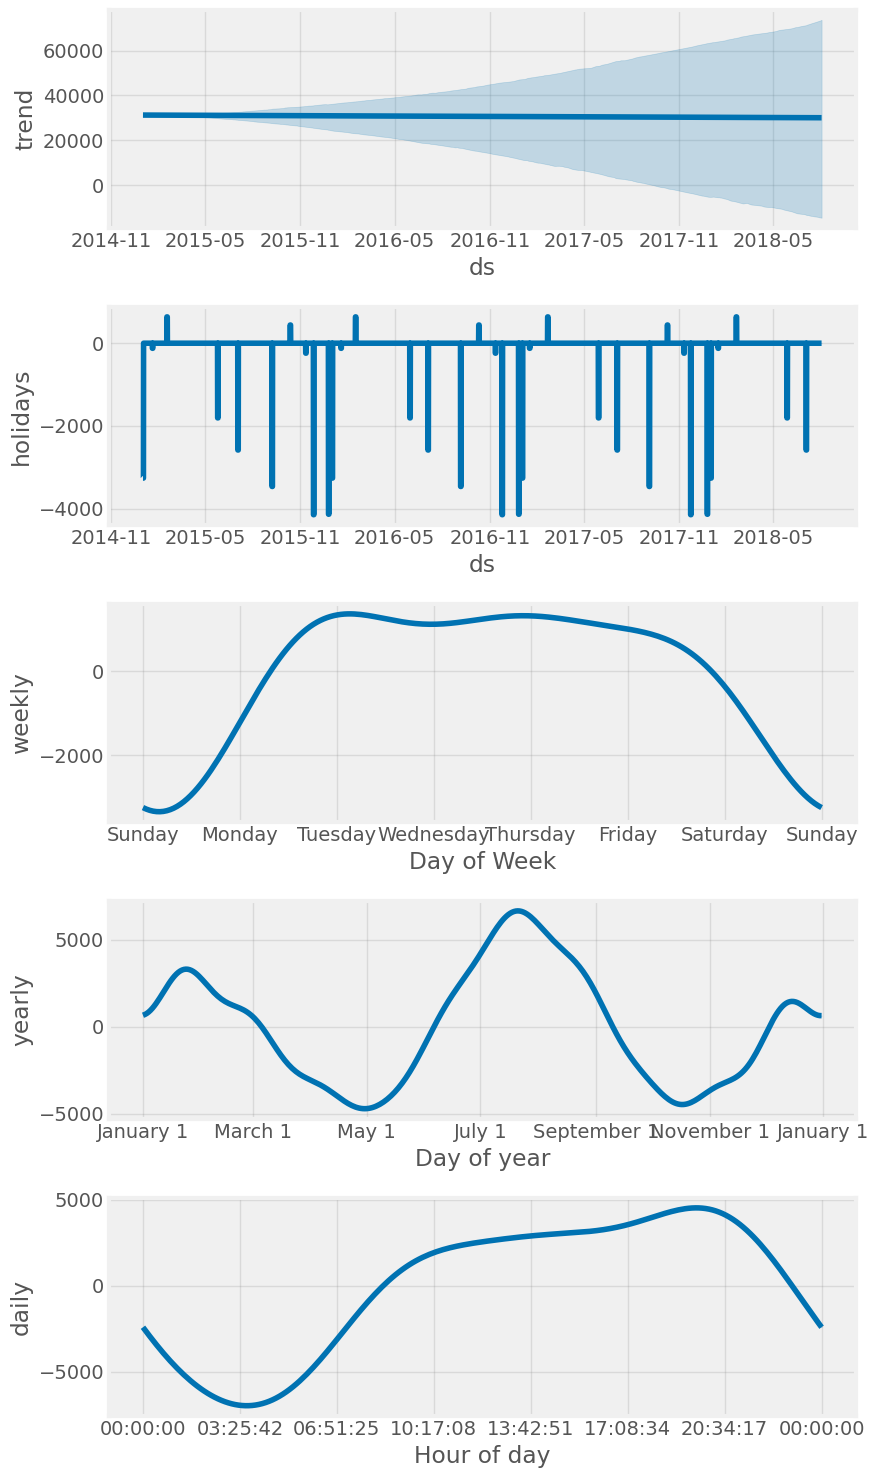

In [88]:
# Visualize the components (trends, seasonality)
fig = model_with_holidays.plot_components(pjme_test_fcst_with_hols)
plt.show()

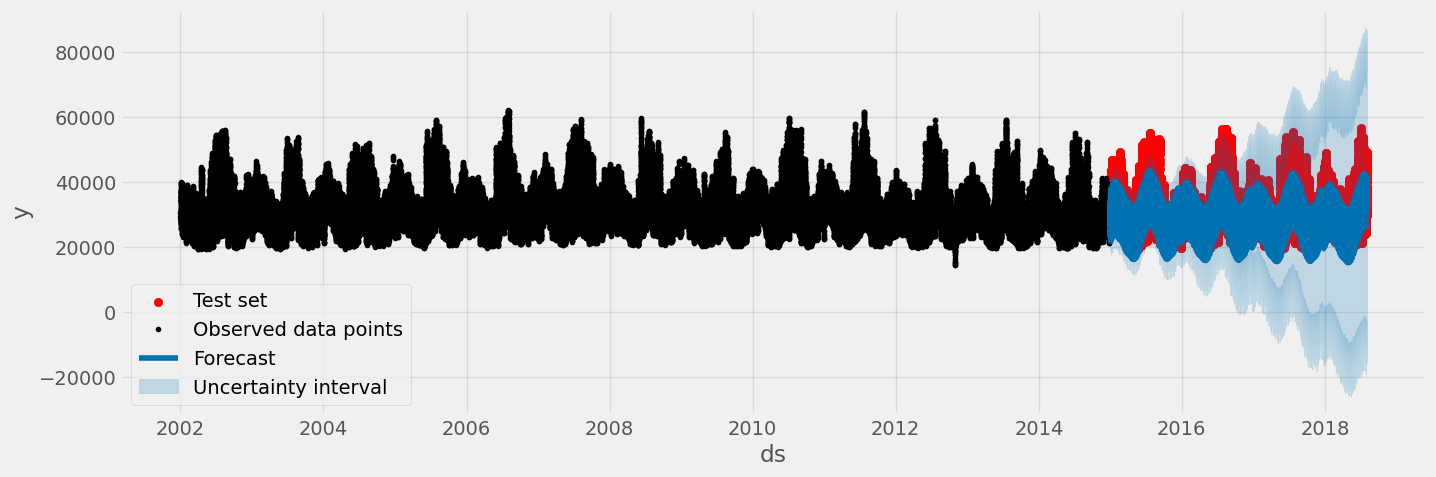

In [89]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r', label='Test set')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)
plt.legend()
plt.show()

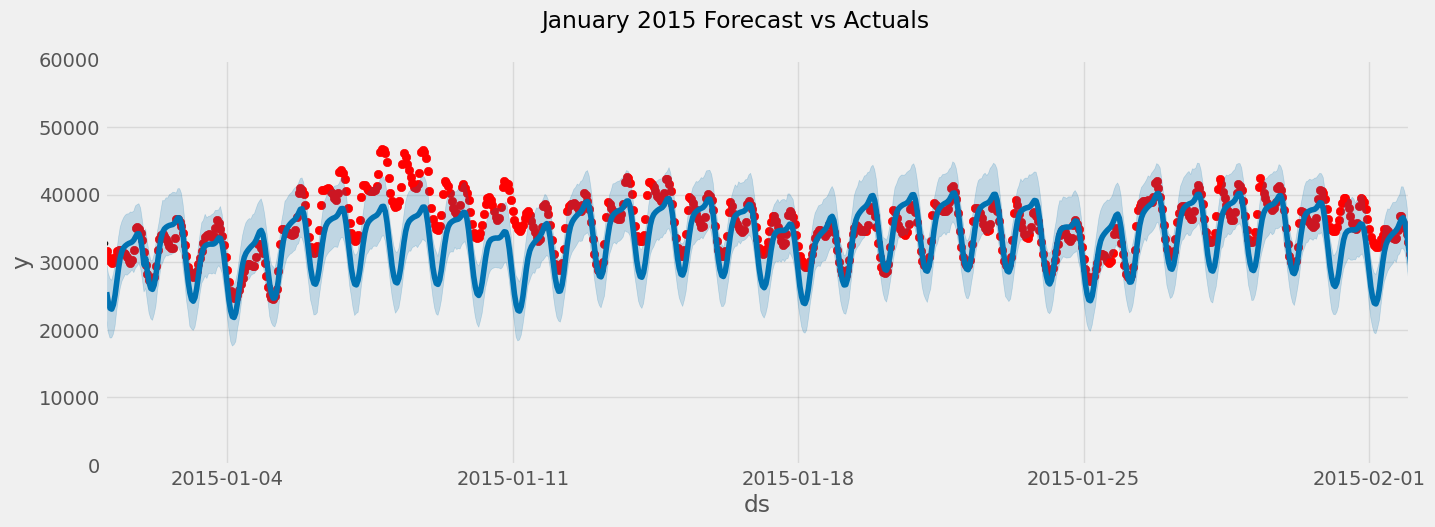

In [91]:
# Forecasting for a specific date
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, 
           pjme_test['PJME_MW'], 
           color='r')

fig = model.plot(pjme_test_fcst_with_hols, 
                 ax=ax)
ax.set_xbound(lower=pd.to_datetime('2015-01-01'), 
              upper=pd.to_datetime('2015-02-02'))
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals (taking in consideration Holidays)')

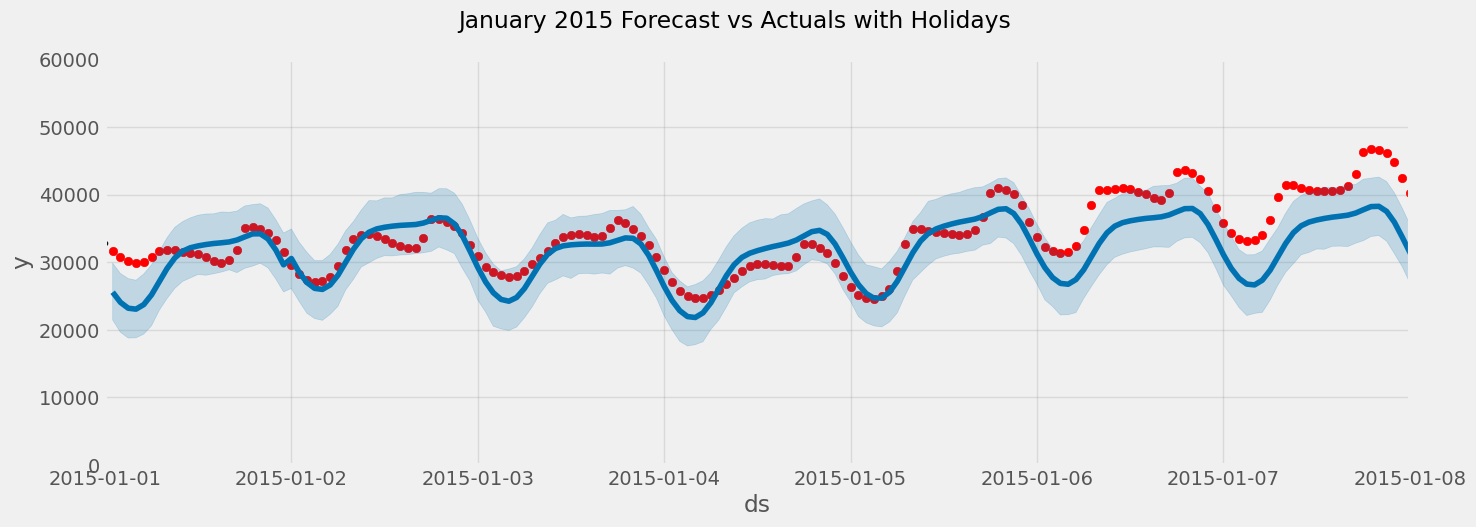

In [92]:
# Forecasting for a specific date
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, 
           pjme_test['PJME_MW'], 
           color='r')

fig = model.plot(pjme_test_fcst_with_hols, 
                 ax=ax)
ax.set_xbound(lower=pd.to_datetime('2015-01-01'), 
              upper=pd.to_datetime('2015-01-08'))
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals with Holidays')

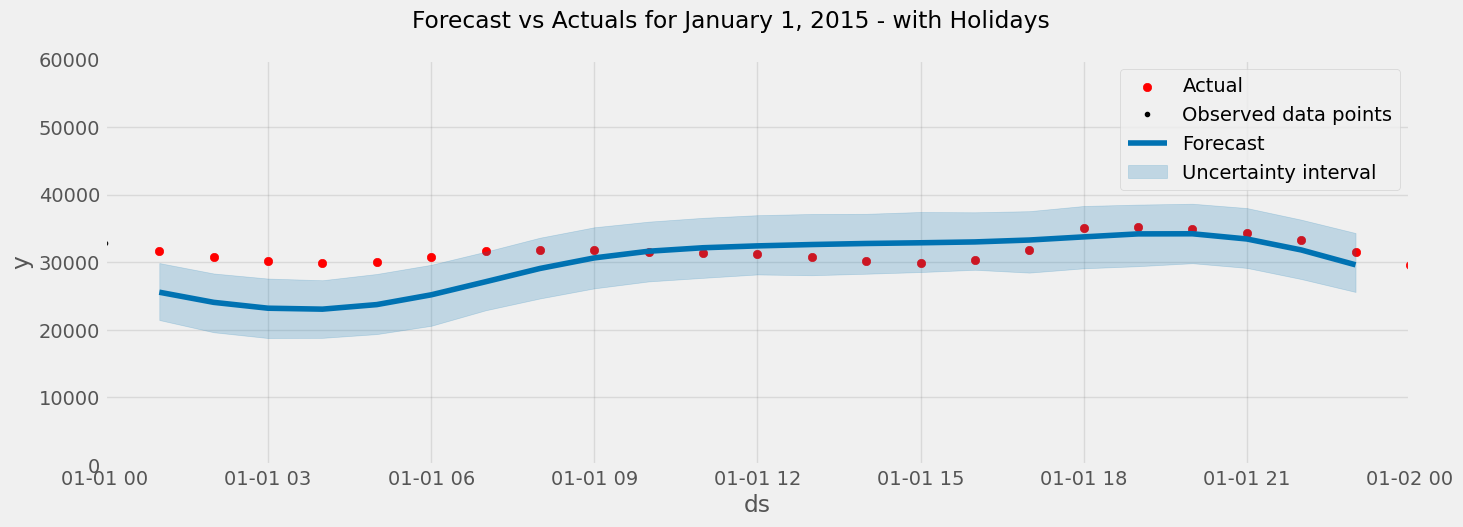

In [94]:
# One day forecast
import pandas as pd
import matplotlib.pyplot as plt

# Assuming pjme_test is your actual data DataFrame and pjme_test_fcst is your forecast DataFrame

# Filter forecast data for January 1, 2015
pjme_test_fcst_filtered = pjme_test_fcst_with_hols[
    (pjme_test_fcst_with_hols['ds'] >= '2015-01-01 00:00:00') & 
    (pjme_test_fcst_with_hols['ds'] <= '2015-01-01 23:59:00')
]

# First Day of January Forecast vs Actuals
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the actual data
ax.scatter(pjme_test.index, 
           pjme_test['PJME_MW'], 
           color='r', label='Actual')

# Plot the filtered forecast data
fig = model.plot(pjme_test_fcst_filtered, 
                 ax=ax)

# Set the x-axis bounds to only show January 1, 2015
ax.set_xbound(lower=pd.to_datetime('2015-01-01'), 
              upper=pd.to_datetime('2015-01-02'))  # Upper bound is set to the next day

# Set the y-axis limit
ax.set_ylim(0, 60000)

# Add a title and legend
plt.suptitle('Forecast vs Actuals for January 1, 2015 - with Holidays ')
plt.legend()
plt.show()


### Evaluate the model with Error Metrics

In [96]:

np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                           y_pred=pjme_test_fcst_with_hols['yhat']))

6635.663701334185

In [97]:

mean_absolute_error(y_true=pjme_test['PJME_MW'],
                    y_pred=pjme_test_fcst_with_hols['yhat'])

5198.953628812672

In [98]:

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                               y_pred=pjme_test_fcst_with_hols['yhat'])

16.562697535721984

### Predict into the Future
- We can use the built in `make_future_dataframe` method to build our future dataframe and make predictions.

In [135]:
future = model.make_future_dataframe(periods=365*24, 
                                     freq='h', 
                                     include_history=False)
forecast = model_with_holidays.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

                      ds          yhat    yhat_lower    yhat_upper
0    2015-01-01 01:00:00  25537.447405  21001.933317  29880.234759
1    2015-01-01 02:00:00  24035.495631  19350.070266  28349.677569
2    2015-01-01 03:00:00  23165.961037  18500.656163  27733.082736
3    2015-01-01 04:00:00  23026.348547  18487.011312  27461.664591
4    2015-01-01 05:00:00  23702.320333  19390.217872  28043.282880
...                  ...           ...           ...           ...
8755 2015-12-31 20:00:00  37091.988355  29219.798522  45018.612773
8756 2015-12-31 21:00:00  36322.233122  29059.020574  44019.709012
8757 2015-12-31 22:00:00  34696.085627  27594.631079  42462.431845
8758 2015-12-31 23:00:00  32491.348335  25092.687221  39926.774008
8759 2016-01-01 00:00:00  26908.367714  19226.004341  34823.259692

[8760 rows x 4 columns]


### Forecasting the Future

In [139]:

# Create a future DataFrame starting from '2018-08-03' to '2019-08-04'

# Define the start and end date for prediction
start_date = pd.Timestamp('2018-08-03')
end_date = pd.Timestamp('2018-09-09')

# Create the future DataFrame
future = pd.date_range(start=start_date, end=end_date, freq='H')
future_df = pd.DataFrame({'ds': future})

# Make predictions for the defined future period
forecast = model.predict(future_df)

# View the forecasted values
#print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])


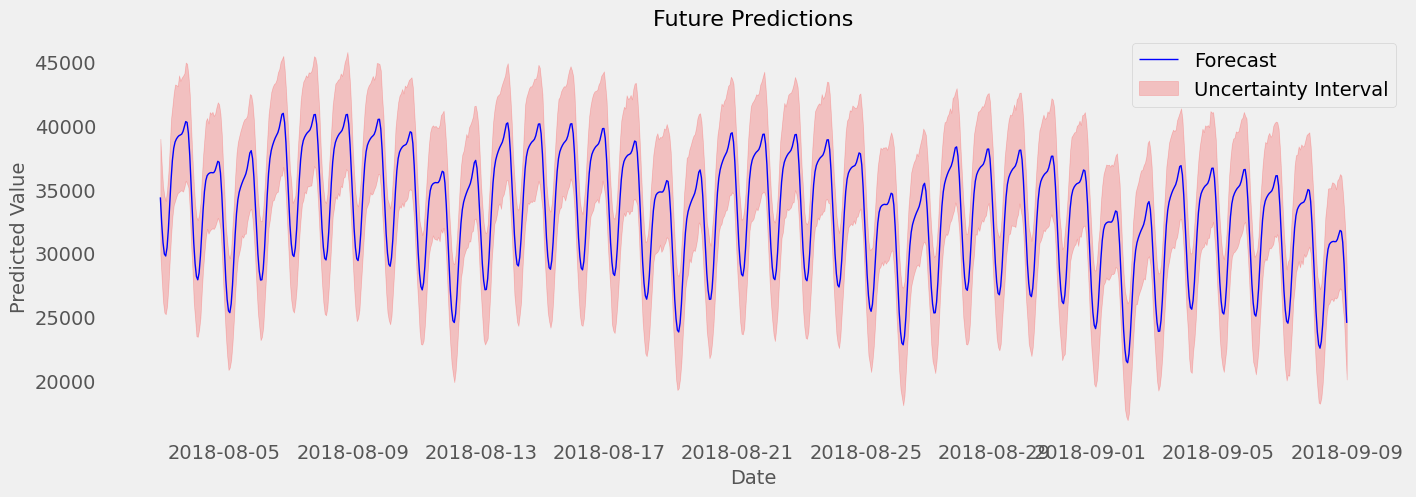

In [140]:
# Visualize the forecast for one Year
plt.figure(figsize=(15, 5))

# Plot the forecast
plt.plot(forecast['ds'], forecast['yhat'], color='blue', label='Forecast', lw=1)  # Change 'blue' to color_pal[4] if you have defined color_pal
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.2, label='Uncertainty Interval')

# Adding titles and labels
plt.title('Future Predictions', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Predicted Value', fontsize=14)
plt.legend()
plt.grid()

# Show the plot
plt.show()


### Saving the Model for later uses

Model saved to FBProphet_model.pkl
Current Directory: C:\Users\xps\Desktop\MLProjects\ML\6.T.S. Forecasting
Files in Directory: ['.ipynb_checkpoints', 'energy_consumption_2_years.csv', 'FBProphet_model.pkl', 'Forecasting_T.S._Classical_Statistical_Models.ipynb', 'Forecasting_T.S._ML_Models.ipynb', 'luxembourg_temperature.csv', 'model.json', 'multivariate_energy_data.csv', 'PJME_hourly.csv', 'Prophet Model.ipynb', 'XGBoost.ipynb']
Model loaded successfully


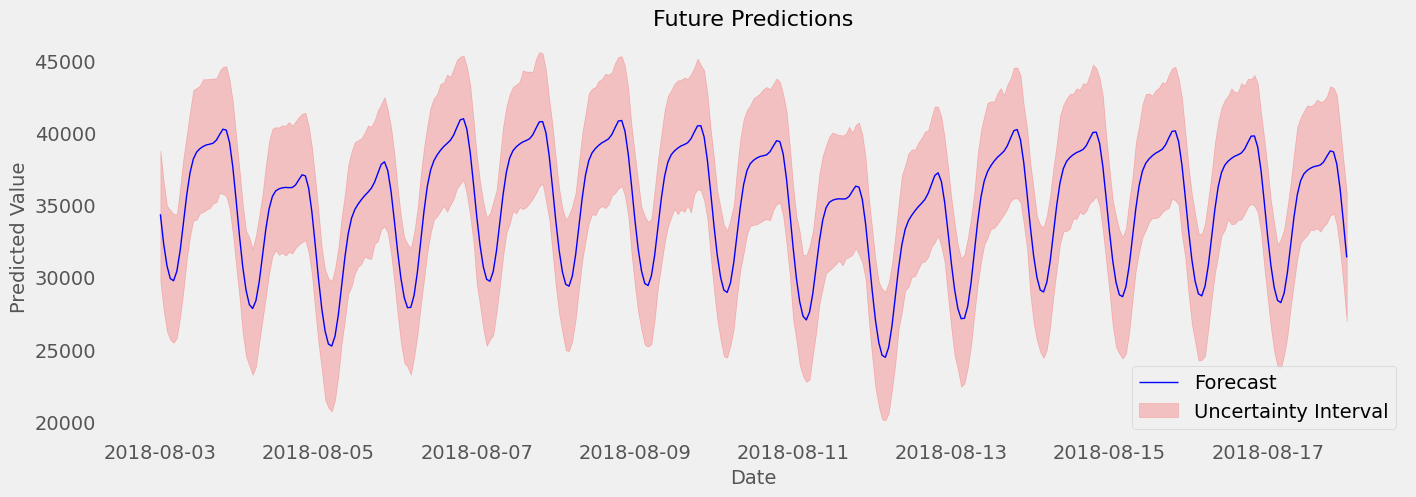

In [144]:
# Verify Model Saving
from prophet import Prophet
import pickle

# Save the fitted model using pickle
with open('FBProphet_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("Model saved to FBProphet_model.pkl")

# Check current directory
import os
print("Current Directory:", os.getcwd())
print("Files in Directory:", os.listdir())

# Load the Model
with open('FBProphet_model.pkl', 'rb') as f:
    model_new = pickle.load(f)
print("Model loaded successfully")

# Define the start and end date for prediction
start_date = pd.Timestamp('2018-08-03 00:00')
end_date = pd.Timestamp('2018-08-18 00:00')

# Create the future DataFrame
future = pd.date_range(start=start_date, end=end_date, freq='H')
future_df = pd.DataFrame({'ds': future})

# Make predictions for the defined future period
#forecast = model.predict(future_df)
forecast = model_with_holidays.predict(future_df)

# Visualize the forecast for one Year
plt.figure(figsize=(15, 5))

# Plot the forecast
plt.plot(forecast['ds'], forecast['yhat'], color='blue', label='Forecast', lw=1)  # Change 'blue' to color_pal[4] if you have defined color_pal
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.2, label='Uncertainty Interval')

# Adding titles and labels
plt.title('Future Predictions', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Predicted Value', fontsize=14)
plt.legend()
plt.grid()

# Show the plot
plt.show()